# Impact of price concessions in NHS in England

## 1.  Import data into notebook

In [1]:
#import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import HTML
from datetime import datetime

#Suppress scientific notation#
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"

df = pd.read_gbq("""
SELECT
  DATE(presc.month) AS month,
  ncso.bnf_code,
  ncso.dmd_name,
  CASE
    WHEN ncso.bnf_code='0702010F0AAACAC' THEN SUM(presc.quantity/80) --adjusting estriol cream quantity
    ELSE SUM(presc.quantity)
  END AS quantity,
  SUM(presc.items) AS items,
  ncso.dmd_quantity,
  ncso.ncso_price,
  dt.dt_price,
  SUM(CASE
      WHEN ncso.bnf_code='0702010F0AAACAC' THEN (presc.quantity/80)*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 --adjusting estriol cream quantity
      ELSE presc.quantity*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 END) AS excess_cost
FROM
  richard.price_concessions AS ncso
INNER JOIN
  hscic.normalised_prescribing_standard AS presc
ON
  presc.month=ncso.month
  AND presc.bnf_code=ncso.bnf_code
INNER JOIN
  richard.drug_tariff AS dt
ON
  dt.month = ncso.month
  AND dt.vmpp = ncso.vmpp
GROUP BY
  month,
  ncso.bnf_code,
  ncso.dmd_name,
  ncso.ncso_price,
  dt.dt_price,
  ncso.dmd_quantity
ORDER BY
  month,
  ncso.dmd_name
""", projectid,dialect='standard')

Requesting query... ok.
Job ID: job_tXAvKq_eI0-90EPLcDv-n0HzaXwX
Query running...
Query done.
Cache hit.

Retrieving results...
Got 854 rows.

Total time taken 1.53 s.
Finished at 2017-12-05 22:43:12.


In [3]:
#create month as index for graphing purposes
df['month'] = pd.to_datetime(df['month'])
df.index = df['month']
del df['month']

## 2. Total number of formulations subject to price concession

In [4]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"
total_df = pd.read_gbq("""
SELECT
  DATE(month) AS month,
  COUNT(vmpp) AS number_of_products
FROM
  richard.price_concessions
  group by month
  order by month
""", projectid,dialect='standard')

Requesting query... ok.
Job ID: job_Hhg0Izs7Z9FefVPjotugfUWe7iIN
Query running...
Query done.
Cache hit.

Retrieving results...
Got 39 rows.

Total time taken 1.03 s.
Finished at 2017-12-05 22:43:34.


In [5]:
#create grouped df for excess cost
total_df['month'] = pd.to_datetime(total_df['month'])
total_df.index = total_df['month']
del total_df['month']

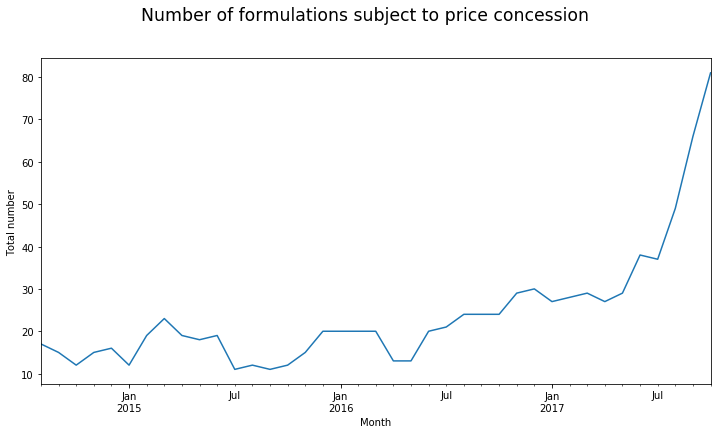

In [6]:
#Showing number of products affected per month
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
total_df.plot(ax=ax, legend=False, y='number_of_products')
#fmt = '{x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Total number")
plt.suptitle('Number of formulations subject to price concession', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

## 3.  Showing number of prescriptions affected over time

In [8]:
#create grouped df for items
items_df=df.groupby([df.index]).sum()
#create table version (without index and other columns and format number)
tbl_items_df = items_df[['items']].copy()
tbl_items_df.reset_index(level=0, inplace=True)

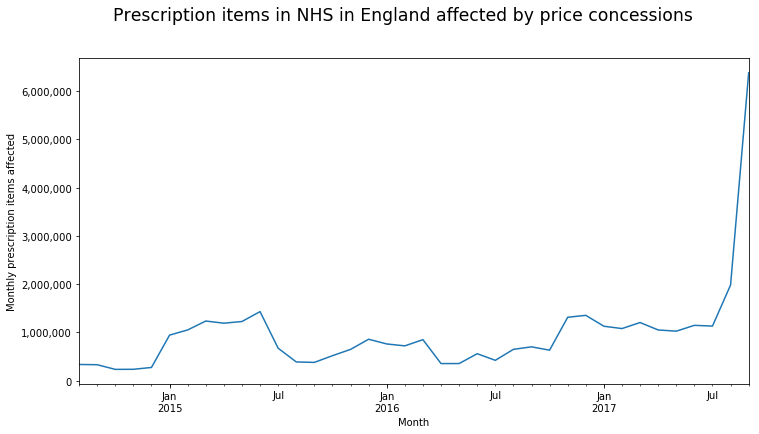

In [9]:
#Plot items chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
items_df.plot(ax=ax, legend=False, y='items')
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Monthly prescription items affected")
plt.suptitle('Prescription items in NHS in England affected by price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [10]:
#produce HTML table of costs
tbl_items_df["month"] = tbl_items_df["month"].dt.strftime("%B %Y")
HTML(tbl_items_df.to_html(index=False, classes='table table-striped'))


## 4.  Showing change over time in excess cost

In [11]:
#create grouped df for excess cost
time_df=df.groupby([df.index]).sum()
#create table version (without index and other columns and format number)
tbl_time_df = time_df[['excess_cost']].copy()
tbl_time_df.reset_index(level=0, inplace=True)
tbl_time_df['excess_cost'] = tbl_time_df['excess_cost'].map('£{:,.0f}'.format) 

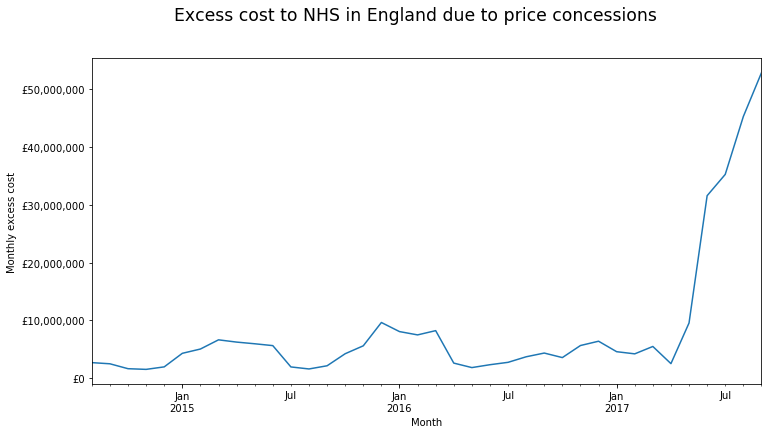

In [12]:
#Plot excess cost chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
time_df.plot(ax=ax, legend=False, y='excess_cost')
fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Monthly excess cost")
plt.suptitle('Excess cost to NHS in England due to price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [13]:
#produce HTML table of costs
tbl_time_df["month"] = tbl_time_df["month"].dt.strftime("%B %Y")
HTML(tbl_time_df.to_html(index=False, classes='table table-striped'))


## 5.  Showing cumulative costs in 2017-18

In [14]:
#create 2017-18 dataframe
fy_time_df= time_df.loc[time_df.index >= '2017-04-01']
fy_time_df['cumulative_cost'] = fy_time_df.excess_cost.cumsum()

#create table version (without index and other columns and format number)
tbl_fy_time_df = fy_time_df[['excess_cost', 'cumulative_cost']].copy()
tbl_fy_time_df.reset_index(level=0, inplace=True)
tbl_fy_time_df['excess_cost'] = tbl_fy_time_df['excess_cost'].map('£{:,.0f}'.format)
tbl_fy_time_df['cumulative_cost'] = tbl_fy_time_df['cumulative_cost'].map('£{:,.0f}'.format) 

C:\Users\racro\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


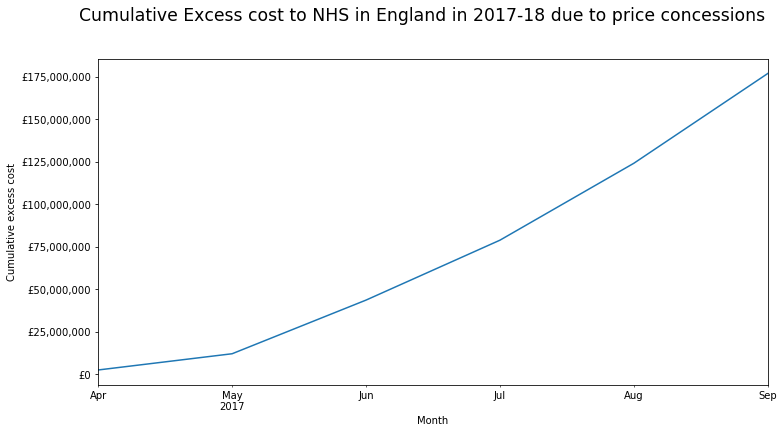

In [15]:
#draw graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fy_time_df.plot(ax=ax, legend=False, y='cumulative_cost')
fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative excess cost")
plt.suptitle('Cumulative Excess cost to NHS in England in 2017-18 due to price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [16]:
#produce HTML table of costs
tbl_fy_time_df["month"] = tbl_fy_time_df["month"].dt.strftime("%B %Y")
HTML(tbl_fy_time_df.to_html(index=False, classes='table table-striped'))

## 6. Top 20 Formulations and their costs in 2017-2018

In [17]:
#create 2017-18 dataframe
cfy_df= df.loc[df.index >= '2017-04-01']

In [18]:
#create top 20 of costs grouped by dmd_name
cfy_df=cfy_df.groupby(['dmd_name']).sum()
tbl_cfy_df = cfy_df[['excess_cost']].copy()
tbl_cfy_df.reset_index(level=0, inplace=True)
tbl_cfy_df.sort_values('excess_cost', inplace=True, ascending=False)
tbl_cfy_df=tbl_cfy_df.nlargest(20,'excess_cost')
tbl_cfy_df['excess_cost'] = tbl_cfy_df['excess_cost'].map('£{:,.0f}'.format)

In [19]:
HTML(tbl_cfy_df.to_html(index=False, classes='table table-striped'))

## 7. Impact on individual CCGs in 2017-2018

In [20]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"

ccg_df = pd.read_gbq("""
SELECT
  DATE(presc.month) AS month,
  ccg.code,
  ccg.name,
  ncso.bnf_code,
  ncso.dmd_name,
  CASE
    WHEN ncso.bnf_code='0702010F0AAACAC' THEN SUM(presc.quantity/80) --adjusting estriol cream quantity
    ELSE SUM(presc.quantity)
  END AS quantity,
  ncso.dmd_quantity,
  ncso.ncso_price,
  dt.dt_price,
  SUM(CASE
      WHEN ncso.bnf_code='0702010F0AAACAC' THEN (presc.quantity/80)*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 --adjusting estriol cream quantity
      ELSE presc.quantity*((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100 END) AS excess_cost
FROM
  richard.price_concessions AS ncso
INNER JOIN
  hscic.normalised_prescribing_standard AS presc
ON
  presc.month=ncso.month
  AND presc.bnf_code=ncso.bnf_code
INNER JOIN
  richard.drug_tariff AS dt
ON
  dt.month = ncso.month
  AND dt.vmpp = ncso.vmpp
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct = ccg.code
WHERE
  ccg.org_type='CCG'
  and presc.month>='2017-04-01 00:00:00'
GROUP BY
  month,
  ncso.bnf_code,
  ncso.dmd_name,
  ncso.ncso_price,
  dt.dt_price,
  ncso.dmd_quantity,
  ccg.code,
  ccg.name
ORDER BY
  month,
  ncso.dmd_name
  """, projectid,dialect='standard')

Requesting query... ok.
Job ID: job_SFg6Tv3obggX_bRnIf0u03bwn-gE
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 100% done. Elapsed 8.09 s.
Got 49727 rows.

Total time taken 9.05 s.
Finished at 2017-12-05 22:45:31.


In [21]:
ccg_df['month'] = pd.to_datetime(ccg_df['month'])
ccg_df.index = ccg_df['month']
del ccg_df['month']
total_ccg_df=ccg_df.groupby(['name']).sum()
total_ccg_df=total_ccg_df.drop(['quantity','dmd_quantity','ncso_price','dt_price'], axis=1)


In [22]:
total_month_ccg_df=ccg_df.groupby(['month','name']).sum()
total_month_ccg_df=total_month_ccg_df.drop(['quantity','dmd_quantity','ncso_price','dt_price'], axis=1)
total_month_ccg_df=total_month_ccg_df.reset_index()
#total_month_ccg_df["month"] = total_month_ccg_df["month"].dt.strftime("%B %Y")



In [25]:
import seaborn as sns
import matplotlib as mpl


g = sns.FacetGrid(total_month_ccg_df, col="name",col_wrap=3,size=6,aspect=2,sharex=False, sharey=False)
g.map_dataframe(plt.plot, 'month', 'excess_cost',)
g.set_titles("{col_name}")
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.tight_layout()
plt.show()


In [27]:
total_ccg_df.reset_index(level=0, inplace=True)
total_ccg_df.sort_values('excess_cost', inplace=True, ascending=False)


In [28]:
total_ccg_df['excess_cost'] = total_ccg_df['excess_cost'].map('£{:,.0f}'.format)

In [29]:
HTML(total_ccg_df.to_html(index=False, classes='table table-striped'))